In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
from Problem.Congestion_VRP import *
from Problem.GIFGenerator import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK50_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}.txt".format(dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}_coordinates.csv'.format(dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK50_1":[0,6,10,15,21,35,40],"UK75_1":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK50_1":[4,20,2,5,32,45,1],"UK75_1":[0,6,10,15,21,35,40,60,31,68]}



In [3]:
startNodeIndeces = startNodes[dataset]
endNodeIndeces = endNodes[dataset]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands
#station_data.iloc[startNodeIndeces+endNodeIndeces,"Demand(kg)"] = 0

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}

#old_init_sol = create_initial_solution(locationNodeIndeces,vehicles,endNodeIndeces,fuel_consumption_wong,cost_function_dict)

#initial_solution_no_starts =initial_solution_kmeans(locationNodeIndeces,endNodeIndeces,points_coordinate,translate_dict)# 
data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution["flattened"],
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':5,'number_of_cities':routingContext.distance_matrix.shape[0]}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution["flattened"],
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':5,'number_of_cities':routingContext.distance_matrix.shape[0]}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[],'fuel_consumption':[],'computation_times':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}


In [4]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = [{"mutation":0.5,"crossover":0.2}]





for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(1):
        
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = 10000
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=10,
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * 10
        performance_observer_NSGAIII.currentEpoch = (index*10) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0].path)
        
nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)



#get_results(nsga3_numerical_path,problem_NSGAIII.routing_context.distance_matrix,station_data,meta_data,time_matrix_here)

Epoch:1 of 10
Evaluations: 10000/10000
Params: {'mutation': 0.5, 'crossover': 0.2} 
IGD:1727.8906841241396
Best fitness: 208.0033 --- 1718.9833                        
Best total fuel consumption:208.0 
Computing time: 10.7s                        
Average computing speed: 934.88it/s
Current Route:[['V4', 41, 36, 43, 42, 33, 28, 23, 9, 1], ['V1', 46, 27, 26, 37, 44, 7, 48, 4], ['V2', 11, 18, 39, 20], ['V3', 47, 34, 19, 30, 16, 38, 24, 2], ['V0', 29, 14, 13, 25, 50, 8, 31, 2], ['V5', 17, 22, 49, 3, 12, 20]]
Flags: []                        
Violation:0
Vehicle amount:6


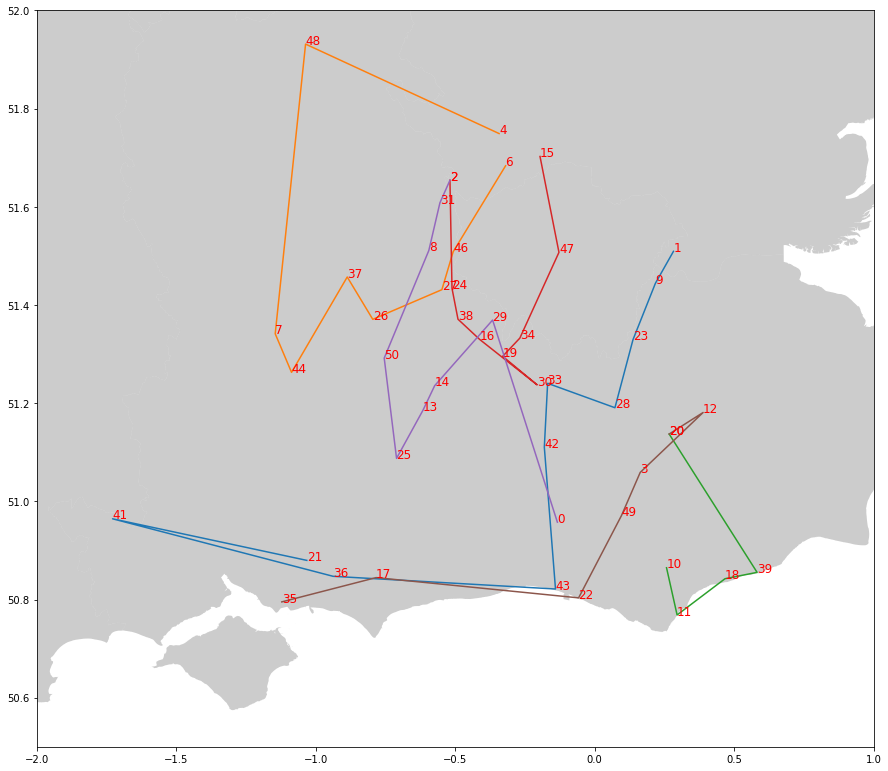

<Figure size 720x720 with 0 Axes>

In [5]:
fig,_ = plot_routes(nsga3_numerical_path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
fig.set_size_inches(15,15)
plt.xlim(-2,1)
plt.ylim(50.5,52)
plt.figure(figsize=(10,10))
plt.show()


In [6]:
paths_sorted_length = sorted(nsga3_numerical_path,key=lambda x: len(x),reverse=True)
longest_path = paths_sorted_length[0]
longest_path_length = len(longest_path)
congestion_point = random.randint(1,longest_path_length - 2)
congestion_edge = (longest_path[congestion_point-1],longest_path[congestion_point])
longest_path_shifted = np.roll(longest_path,-1)
drivetimes = time_matrix_here[longest_path[:-1],longest_path_shifted[:-1]]
congestion_time = np.cumsum(drivetimes)[congestion_point]
congestion_time
locked_paths = {}
for path in front_NSGAIII[0].path:
    
    locked_paths[path[0]] = [path[0]]
    vehicle_index = [vehicles[path[0]]["startPos"]]
    numerical_route = vehicle_index +  path[1:]
    numerical_route_shifted = np.roll(numerical_route,-1)
    
    drive_times = time_matrix_here[numerical_route,numerical_route_shifted]
    drive_times[-1] = 0
    drive_times_cumul = np.cumsum(drive_times)
    test = len(list(filter(lambda x: x < congestion_time, drive_times_cumul)))
    
    edge_drive_times = list(zip(numerical_route,drive_times_cumul))
    locked_paths[path[0]].extend(path[1:test])

unused_vehicles = list(filter(lambda x: not x in locked_paths.keys(),vehicles.keys()))
for unused_vehicle in unused_vehicles:
    locked_paths[unused_vehicle] = [unused_vehicle]

for index,vehicle in enumerate(locked_paths):

    if locked_paths[vehicle][-1] in endNodeIndeces:
        locked_paths[vehicle].pop()
        
current_sol = [x if not x in endNodeIndeces else 100 + index for index, x in enumerate(list(chain(*front_NSGAIII[0].path)))]
locked_pickups = list(filter(lambda x: type(x) != str and not x in endNodeIndeces,chain(*locked_paths.values())))
print(congestion_edge)
locked_paths

(43, 42)


{'V4': ['V4', 41, 36, 43],
 'V1': ['V1', 46, 27, 26, 37, 44],
 'V2': ['V2', 11, 18, 39],
 'V3': ['V3', 47, 34, 19, 30, 16, 38, 24],
 'V0': ['V0', 29, 14, 13, 25, 50, 8, 31],
 'V5': ['V5', 17, 22, 49, 3, 12],
 'V6': ['V6']}

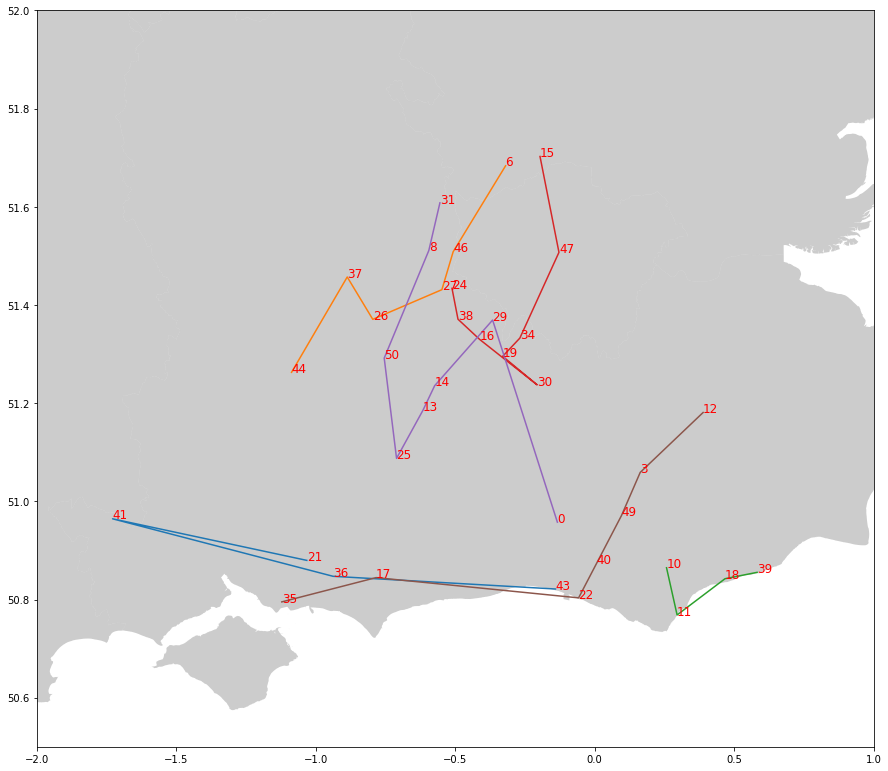

In [7]:

fig,_ = plot_routes(get_numerical_path(list(locked_paths.values()),vehicles),points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
fig.set_size_inches(15,15)
plt.xlim(-2,1)
plt.ylim(50.5,52)
# plt.xlim(-3,0)
# plt.ylim(51.5,54)
plt.show()


In [8]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
import collections
from bisect import bisect_left
import datetime
from Problem.utils import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.VRP import * 

def shuffle_paths(variables,ends=None):
    result = []
    end_indices = []
    end_indices = np.where(np.array(variables)>=100)[0]
    prevIndex = 0
    for endIndex in end_indices:
        sub_list = variables[prevIndex:endIndex]
        sub_list = random.sample(sub_list,k=len(sub_list))
        sub_list.append(variables[endIndex])
        
        prevIndex=endIndex+1  
        
        result.extend(sub_list)

    return result


class Congestion_VRP(VRP):
    
    def __init__(self,problemData,currentSolution = None,locked_pickup_points=None):
        check_type(problemData,dict)
        super(Congestion_VRP,self).__init__(problemData)
        self.locked_pickup_points = locked_pickup_points
        self.locked_paths = {}
        self.new_init = currentSolution
        
    def set_locked_paths(self,locked_paths):
        self.locked_paths = locked_paths
    
    def set_congestion(self,edge,value):
        if not hasattr(self,"original_time_matrix"):
            self.original_time_matrix = self.routing_context.time_matrix
            
        self.routing_context.time_matrix[edge] += value
        
    def reset_congestion(self):
        if hasattr(self,"original_time_matrix"):
            self.routing_context.time_matrix = self.original_time_matrix
        
    def create_paths(self,solution):
        vehicle_order = list(filter(lambda x: type(x) == str,solution.variables))
        
        if len(self.locked_paths) > 0:
            paths = list([self.locked_paths[x] for x in vehicle_order])
        else:
            paths = list([[x] for x in vehicle_order])
        
        relevant_variables = list(filter(lambda x: not x in list(chain(*paths)),solution.variables))
        
        vehicle_index=0
        for index, node_index in enumerate(relevant_variables):
            
            if type(node_index) != str:

                if vehicle_index == len(paths):
                    solution.constraints[4] -= ((len(relevant_variables)-1)-index)*100
                    paths[-1].append(node_index)
                elif node_index >= 100:
                    if not self.assignClosestEndPoint:
                        paths[vehicle_index].append(node_index)
                    vehicle_index+=1
                else:

                    paths[vehicle_index].append(node_index)

        filtered_path =list(filter(lambda path: len(path) > 1,paths))
        filtered_path_with_ends = self.assingEndPositions(filtered_path)
        #print(filtered_path)
        return filtered_path_with_ends 
    
    def assingEndPositions(self,paths):
        for index,path in enumerate(paths):
            if not paths[index][-1] in self.end_positions:
                paths[index].append(self.end_positions[int(np.argsort(self.routing_context.distance_matrix[path[-1],self.end_positions])[0])])    
        return paths
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,
                                           number_of_objectives=self.number_of_objectives,
                                           number_of_constraints=self.number_of_constraints)        
        
        if self.new_init != None:
            new_solution.variables = deepcopy(self.new_init)
        else:
            new_solution.variables = deepcopy(self.initial_solution)
        #print(new_solution.variables)
        if self.locked_pickup_points != None:
            for pickup_point in self.locked_pickup_points:
                #print(pickup_point)
                new_solution.variables.remove(pickup_point)
            new_solution.number_of_variables = len(new_solution.variables)
            
        return new_solution
        
    def get_name(self):
        return self.name
    


In [9]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameter_list_NSGAIII = [{"mutation":0.6,"crossover":0.2}]

for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(1):
        
        problem_NSGAIII = Congestion_VRP(data_model_input_multi_objective,currentSolution =current_sol,locked_pickup_points=locked_pickups )
        problem_NSGAIII.set_locked_paths(locked_paths)
        problem_NSGAIII.set_congestion(congestion_edge,1*60*60)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = 5000
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=10,
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * 10
        performance_observer_NSGAIII.currentEpoch = (index*10) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII_dynamic = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII_dynamic[0].path)
        
nsga3_numerical_path_dynamic = get_numerical_path(front_NSGAIII_dynamic[0].path,vehicles)



#get_results(nsga3_numerical_path,problem_NSGAIII.routing_context.distance_matrix,station_data,meta_data,time_matrix_here)

Epoch:1 of 10
Evaluations: 5000/5000
Params: {'mutation': 0.6, 'crossover': 0.2} 
IGD:1849.789077435202
Best fitness: 232.5219 --- 1835.1167                        
Best total fuel consumption:232.52 
Computing time: 5.3s                        
Average computing speed: 942.59it/s
Current Route:[['V4', 41, 36, 43, 28, 23, 9, 1], ['V0', 29, 14, 13, 25, 50, 8, 31, 2], ['V2', 11, 18, 39, 42, 33, 48, 4], ['V5', 17, 22, 49, 3, 12, 20], ['V3', 47, 34, 19, 30, 16, 38, 24, 2], ['V1', 46, 27, 26, 37, 44, 7, 45]]
Flags: []                        
Violation:0
Vehicle amount:6


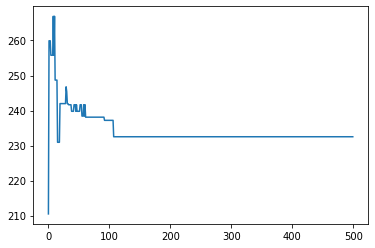

In [10]:
plt.plot(np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0))

In [12]:
color_map = get_vehicle_color_map(vehicles)
generate_routes_gif(performance_observer_NSGAIII,vehicles,points_coordinate,dbf,congestion_edge,color_map,"")

  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 720x720 with 0 Axes>

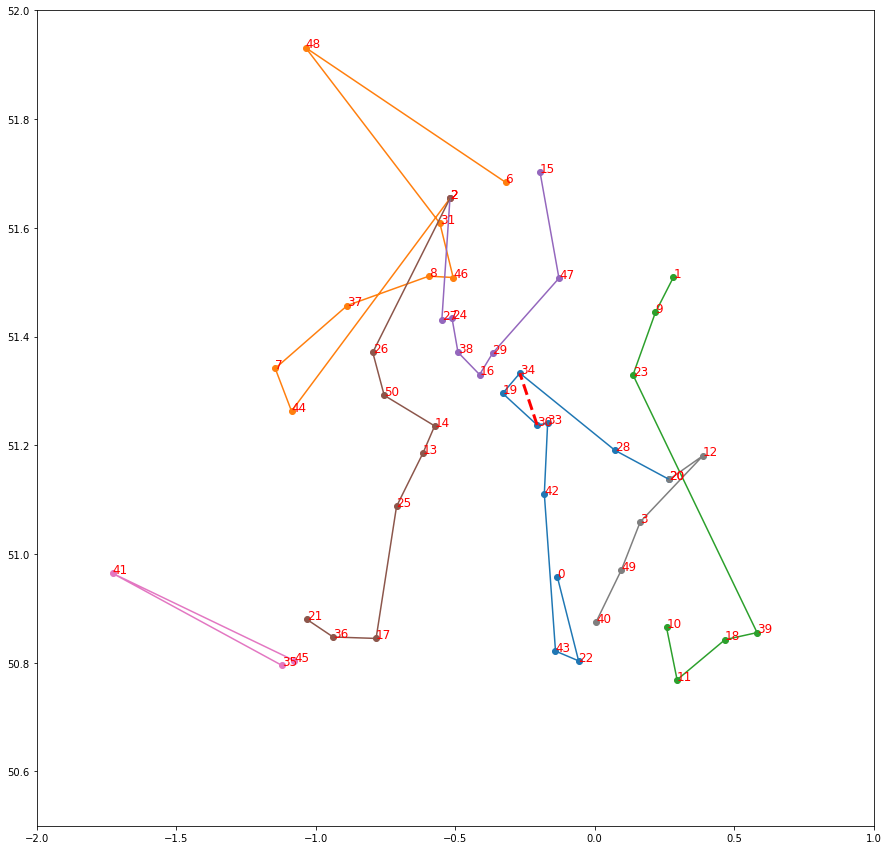

In [25]:

plt.figure(figsize=(10,10))
fig,_ = plot_routes_with_congestion(nsga3_numerical_path_dynamic,points_coordinate,dbf,congestion_edge,colors=color_map,station_ids = True, here_api=False, api_key=api)
fig.set_size_inches(15,15)
plt.xlim(-2,1)
plt.ylim(50.5,52)
# plt.xlim(-3,0)
# plt.ylim(51.5,54)
plt.show()

In [19]:
%matplotlib inline
plt.ioff()
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 100
plots=[]
minx,maxx = np.min(points_coordinate[:,1]),np.max(points_coordinate[:,1])
miny,maxy = np.min(points_coordinate[:,0]),np.max(points_coordinate[:,0])

for index in tqdm(range(len(performance_observer_NSGAIII.path_history))[::10]):
    numerical_path = get_numerical_path(performance_observer_NSGAIII.path_history[index],vehicles)
    
    fig,_ = plot_routes_with_congestion(numerical_path,points_coordinate,dbf,congestion_edge,colors=color_map,station_ids = True, here_api=False, api_key=api)
    fig.set_size_inches(10,10)
    fig.axes[0].set_xlim(-2,1)
    fig.axes[0].set_ylim(50.5,52)
    fig.axes[0].set_title("Fuel Consumption: {} (L)".format(round(performance_observer_NSGAIII.total_consumptions[index],2)),fontsize=20)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plots.append(image)
    plt.close(fig)
    
    


  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
import imageio 
imageio.mimsave('./tester1.gif', plots, fps=10)